In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<h1 align='center'>Ben Prescott, Assignment 2, MSDS422, WI2021</h1>


In [148]:
import os
import re
import dill
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import seaborn as sns
from pandas_profiling import ProfileReport
from pickleshare import *
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split,GridSearchCV, cross_validate
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import skew 

%matplotlib inline
pd.set_option('display.max_columns', None) #Displays all columns for pandas output
sns.set(rc={'figure.figsize':(12,6)}) #Setting seaborn plot size standard

In [ ]:
dill.load_session('saved_notebook.db')

# Objective 0 - Data Load, EDA, Transformations

In [ ]:
df = pd.read_pickle('amesDF.pickle')
df.head()
df.dtypes.value_counts()

In [ ]:
df.info(verbose=True)

In [ ]:
plt.scatter(df['Sale_Price'],df['Gr_Liv_Area'])

In [ ]:
df2 = df[df['Gr_Liv_Area'] <= 4000].copy(deep=True)
print("Observation count of less than 4000 sq ft living area:", len(df2))

dfchar, dfnum = df2.select_dtypes(include=['object']), df2.select_dtypes(exclude=['object'])

In [ ]:
dfchar.dtypes.value_counts()
dfnum.dtypes.value_counts()

In [ ]:
profile = ProfileReport(dfnum, title="Ames Housing Dataset Profile")
profile.to_notebook_iframe()

Finding an observation where the house was apparently remodeled before it was built. Removing to help reduce inaccurate data.

In [ ]:
#View initial shape of dataframe.
dfnum.shape
#Finding if any houses are listed as built after being remodeled.
((dfnum.Year_Built-dfnum.Year_Remod_Add)>0.00).value_counts()
#Copying all rows to a new dataframe, excluding the above found row.
dfnum2=dfnum.loc[~((dfnum.Year_Built-dfnum.Year_Remod_Add)>0.00),:].copy(deep=True)
#Reviewing new dataframe shape to validate row was removed.
dfnum2.shape

Output of Pandas Profiling report alluded to many features with a heavy positive skew. Many are due to things such as many houses not having a three season porch, but Lot_Area seems suspicious due to a few extreme outliers above the 100k mark. Considering K-means is sensitive to outliers I'll be removing these observations.

In [ ]:
fig, axs = plt.subplots(ncols=2)
plt.suptitle("Lot Area Extreme Outliers", fontsize=20)
sns.scatterplot(x='Sale_Price', y='Lot_Area', data=dfnum2, ax=axs[0])
sns.boxplot(x='Lot_Area', data=dfnum2, ax=axs[1])

In [ ]:
dfnum3 = dfnum2[dfnum2['Lot_Area'] <= 100000].copy(deep=True)
fig, axs = plt.subplots(ncols=2)
plt.suptitle("Lot Area Extreme Outliers Removed", fontsize=20)
sns.scatterplot(x='Sale_Price', y='Lot_Area', data=dfnum3, ax=axs[0])
sns.boxplot(x='Lot_Area', data=dfnum3, ax=axs[1])

Referring to the mention of "questionably numeric" features, and some examples in provided notebooks, we'll be adjusting the features with years or months. 

In [ ]:
dfnum3.columns

In [ ]:
smodummies = pd.get_dummies(dfnum3['Mo_Sold'],prefix="Sales_Mo").astype(int)
smodummies.columns

dfnum4 = dfnum3.loc[:,~(dfnum3.columns.isin(['Mo_Sold']))]
dfnum5 = pd.concat([dfnum4,smodummies],axis=1,ignore_index=False)
dfnum5.head()

In [ ]:
dfnum5years = dfnum5.loc[:,['Year_Built','Year_Remod_Add','Year_Sold']].transform(lambda x: 2010-x)
dfnum6 = dfnum5.loc[:,~(dfnum5.columns.isin(['Year_Built','Year_Remod_Add','Year_Sold']))]
dfnum7 = pd.concat([dfnum6,dfnum5years],axis=1)

# Objective 1 - K-Means Clusterings

Removing the Sale_Price data prior to doing K-Means clustering.

In [73]:
saledata, clusdata = dfnum7.loc[:,(dfnum7.columns.isin(['Sale_Price']))].copy(deep=True), dfnum7.loc[:,~(dfnum7.columns.isin(['Sale_Price']))].copy(deep=True)
X = clusdata.to_numpy(copy=True) 
y = saledata.Sale_Price.to_numpy(copy=True)

In [74]:
for i in range(2,13):
    clusters = KMeans(n_clusters=i, random_state=44)
    labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    print("Cluster # =", i,
          f"Silhouette Score: {silhouette_score(X, labels)}",
          f"Davies Bouldin Score: {davies_bouldin_score(X, labels)}",
          f'CH Score: {calinski_harabasz_score(X, labels)}')

Cluster # = 2 Silhouette Score: 0.7596890425207573 Davies Bouldin Score: 0.6135060409995381 CH Score: 2137.7652707642414
Cluster # = 3 Silhouette Score: 0.44068092140725773 Davies Bouldin Score: 0.6810153295064377 CH Score: 3095.83369436093
Cluster # = 4 Silhouette Score: 0.43898709713257017 Davies Bouldin Score: 0.6609269910067859 CH Score: 3766.0838919190173
Cluster # = 5 Silhouette Score: 0.4261086495071589 Davies Bouldin Score: 0.6715196323838235 CH Score: 4171.011762159904
Cluster # = 6 Silhouette Score: 0.38434911330844795 Davies Bouldin Score: 0.7089775898854423 CH Score: 4398.412016066107
Cluster # = 7 Silhouette Score: 0.37285486505761395 Davies Bouldin Score: 0.7075606866901936 CH Score: 4467.637553967823
Cluster # = 8 Silhouette Score: 0.34489017665400656 Davies Bouldin Score: 0.7612934296933396 CH Score: 4542.201364377202
Cluster # = 9 Silhouette Score: 0.30902785493284374 Davies Bouldin Score: 0.8300642080091515 CH Score: 4463.575069416142
Cluster # = 10 Silhouette Score: 

In [75]:
clusters = KMeans(n_clusters=4, random_state=40)
labels = clusters.fit_predict(X)
centers = clusters.cluster_centers_
silhouette_avg = silhouette_score(X, labels)
sample_silhouette_values = silhouette_samples(X, cluster_labels)

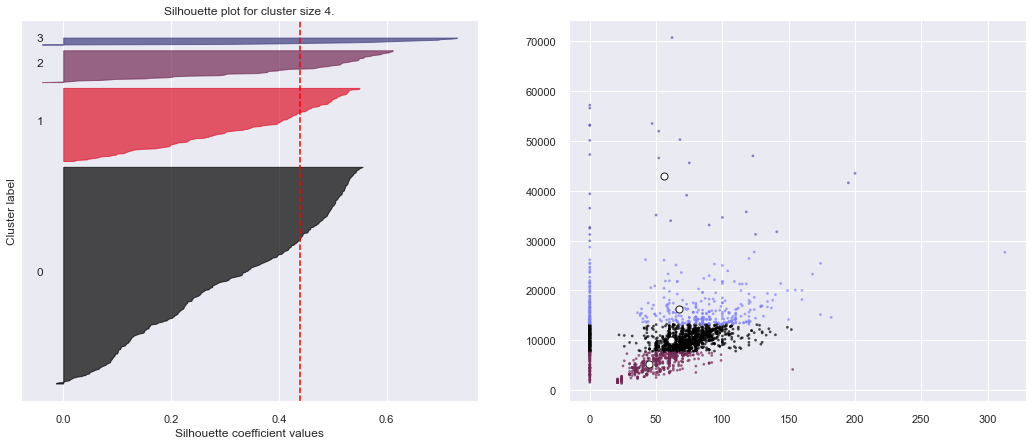

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
ax1.set_title("Silhouette plot for cluster size 4.")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
y_lower = 10

for i in range(clusters.n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.gist_stern(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

colors = cm.gist_stern(labels.astype(float) / 6)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=50, edgecolor='k')
plt.show();

# Objective 2: Rescaling Feature Data

In [77]:
X.shape
y.shape

trainX , testX , trainy , testy = train_test_split(X, y, train_size = 0.85, test_size=0.15, random_state=33)

In [78]:
scaler = StandardScaler()
scaler.fit(trainX)
trainXS = scaler.transform(trainX)
testXS = scaler.transform(testX)

# Objective 3: PCA

In [79]:
pca75 = PCA(n_components=0.75, svd_solver='full')
pca75.fit(trainX)
print("Number of components required for 75% of total variation:", pca75.components_.size)

Number of components required for 75% of total variation: 44


In [80]:
trainXPCA=pca75.transform(trainX)
testXPCA=pca75.transform(testX)
trainXPCA.shape

(2482, 1)

# Objective 4: Training RF Regressors

In [86]:
rfreg = RandomForestRegressor(n_estimators=100, max_features="auto", oob_score=True)
rfreg.fit(trainX, trainy)
ypred = rfreg.predict(testX)

Feature importances, with the higher the score the more important. All values add up to 1. 

In [97]:
pd.DataFrame([rfreg.feature_importances_], columns=clusdata.columns)

,Lot_Frontage,Lot_Area,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,TotRms_AbvGrd,Fireplaces,Garage_Cars,Garage_Area,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,Three_season_porch,Screen_Porch,Pool_Area,Misc_Val,Longitude,Latitude,Sales_Mo_1,Sales_Mo_2,Sales_Mo_3,Sales_Mo_4,Sales_Mo_5,Sales_Mo_6,Sales_Mo_7,Sales_Mo_8,Sales_Mo_9,Sales_Mo_10,Sales_Mo_11,Sales_Mo_12,Year_Built,Year_Remod_Add,Year_Sold
0,0.004816,0.020068,0.024258,0.004546,0.000925,0.009602,0.07185,0.055573,0.006853,0.155381,0.003059,0.00027,0.001906,0.001357,0.005299,0.001499,0.00488,0.028438,0.272638,0.028963,0.005746,0.00607,0.000838,0.000227,0.002912,0.000055,0.000199,0.010345,0.010353,0.000376,0.000886,0.000425,0.000217,0.0003,0.000471,0.000558,0.000359,0.000367,0.001122,0.000738,0.000449,0.225036,0.027383,0.002384


In [90]:
pd.DataFrame({'Pred':ypred, 'Actual':testy}, columns=['Pred','Actual'])

,Pred,Actual
0,177971.53,215000
1,116927.00,116500
2,139839.48,160000
3,234250.60,239500
4,239348.67,218836
...,...,...
433,138582.80,133000
434,436376.10,342000
435,124420.16,93369
436,119566.81,94000


In [104]:
mse = mean_squared_error(testy,ypred)
rmse = np.sqrt(mse)
rmse

23616.041007035514

Training using trainXS and predicting using testXS.

In [105]:
rfreg = RandomForestRegressor(n_estimators=100, max_features="auto", oob_score=True)
rfreg.fit(trainXS, trainy)
ypred = rfreg.predict(testXS)

In [106]:
pd.DataFrame([rfreg.feature_importances_], columns=clusdata.columns)

,Lot_Frontage,Lot_Area,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,TotRms_AbvGrd,Fireplaces,Garage_Cars,Garage_Area,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,Three_season_porch,Screen_Porch,Pool_Area,Misc_Val,Longitude,Latitude,Sales_Mo_1,Sales_Mo_2,Sales_Mo_3,Sales_Mo_4,Sales_Mo_5,Sales_Mo_6,Sales_Mo_7,Sales_Mo_8,Sales_Mo_9,Sales_Mo_10,Sales_Mo_11,Sales_Mo_12,Year_Built,Year_Remod_Add,Year_Sold
0,0.005282,0.02058,0.029384,0.003285,0.000801,0.010014,0.07136,0.060397,0.006844,0.160285,0.003336,0.000256,0.001762,0.001076,0.004613,0.002022,0.005786,0.024101,0.270675,0.023937,0.005778,0.005881,0.001087,0.000123,0.002284,0.000162,0.000276,0.009315,0.010988,0.000293,0.001255,0.000379,0.000245,0.000374,0.000735,0.000486,0.000417,0.00041,0.000935,0.000556,0.000413,0.219899,0.029831,0.002083


In [108]:
pd.DataFrame({'Pred':ypred, 'Actual':testy}, columns=['Pred','Actual'])

,Pred,Actual
0,182841.03,215000
1,115449.60,116500
2,141428.21,160000
3,230857.65,239500
4,235892.95,218836
...,...,...
433,139182.49,133000
434,440158.94,342000
435,120893.51,93369
436,120360.88,94000


In [109]:
mse = mean_squared_error(testy,ypred)
rmse = np.sqrt(mse)
rmse

23547.902725207863

Changing number of trees to 200 and max features to log2. RMSE continues to drop with refinement.

In [121]:
rfreg = RandomForestRegressor(n_estimators=200, max_features="log2", oob_score=True)
rfreg.fit(trainXS, trainy)
ypred = rfreg.predict(testXS)

In [122]:
out = pd.DataFrame({'Pred':ypred, 'Actual':testy}, columns=['Pred','Actual'])

In [123]:
out.describe()

,Pred,Actual
count,438.000000,438.000000
mean,180192.399863,179918.945205
std,70704.719685,79048.640115
min,64544.290000,34900.000000
25%,130575.600000,129000.000000
50%,161791.980000,159450.000000
75%,211334.966250,213750.000000
max,464181.140000,591587.000000


In [124]:
mse = mean_squared_error(testy,ypred)
rmse = np.sqrt(mse)
rmse

23387.502652419087

# Objective 5: Boosted Regression Models

Running a quick GridSearch to determine best number of learners and the learning rate. 

In [132]:
parms = {'n_estimators': [50,100,150,200],'learning_rate':[.25,.50,.75,1]}
adaregr = AdaBoostRegressor()
adaParmCV = GridSearchCV(adaregr,parms)
adaParmCV

GridSearchCV(estimator=AdaBoostRegressor(),
             param_grid={'learning_rate': [0.25, 0.5, 0.75, 1],
                         'n_estimators': [50, 100, 150, 200]})

In [133]:
adaParmFit = adaParmCV.fit(trainX,trainy)
adaParmFit.best_params_

{'learning_rate': 0.5, 'n_estimators': 50}

Identifying ideal parameters from GridSearch.

In [172]:
adaregr = AdaBoostRegressor(n_estimators=50,learning_rate=.5)
adakfold = cross_validate(clone(adaregr),trainX, trainy, cv=10, return_train_score=True,
                       scoring=('r2', 'neg_root_mean_squared_error'))

In [173]:
print('Fold summary stats:')
pd.DataFrame(adakfold).iloc[:,2:].describe()

Fold summary stats:


,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
count,10.000000,10.000000,10.000000,10.000000
mean,0.808369,0.850225,-33874.711491,-30328.997202
std,0.038165,0.003582,2437.013038,358.281437
min,0.741504,0.843708,-38463.144804,-31082.157144
25%,0.790078,0.848889,-34886.259959,-30509.297587
50%,0.815269,0.850109,-34239.387502,-30233.735371
75%,0.835527,0.852942,-32952.580387,-30095.337112
max,0.854681,0.855126,-29452.629658,-29868.615064


Reviewing validation of assignment hyperparmeter recommendations.

In [168]:
adaregr2 = AdaBoostRegressor(n_estimators=100)
adakfold2 = cross_validate(clone(adaregr2),trainX, trainy, cv=10, return_train_score=True,
                       scoring=('r2', 'neg_root_mean_squared_error'))

In [171]:
print('Fold summary stats:')
pd.DataFrame(adakfold2).iloc[:,2:].describe()

Fold summary stats:


,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
count,10.000000,10.000000,10.000000,10.000000
mean,0.800914,0.843070,-34573.286355,-31040.766347
std,0.033446,0.005935,1773.390170,523.673012
min,0.745950,0.835826,-37576.785046,-31561.398855
25%,0.783239,0.839679,-35530.650743,-31409.077651
50%,0.807756,0.841204,-34470.243752,-31212.110726
75%,0.825744,0.844557,-34245.707427,-30980.740561
max,0.842672,0.853632,-30800.110881,-30099.203615


Fitting and training the initial adaregr model.

In [194]:
adaregr = AdaBoostRegressor(n_estimators=50,learning_rate=.5)
adaregr.fit(trainX,trainy)
ypred = adaregr.predict(testX)

In [195]:
adaregr.score(trainX,trainy)

0.8481847038338405

In [182]:
pd.DataFrame([adaregr.feature_importances_], columns=clusdata.columns)

,Lot_Frontage,Lot_Area,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,Second_Flr_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,TotRms_AbvGrd,Fireplaces,Garage_Cars,Garage_Area,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,Three_season_porch,Screen_Porch,Pool_Area,Misc_Val,Longitude,Latitude,Sales_Mo_1,Sales_Mo_2,Sales_Mo_3,Sales_Mo_4,Sales_Mo_5,Sales_Mo_6,Sales_Mo_7,Sales_Mo_8,Sales_Mo_9,Sales_Mo_10,Sales_Mo_11,Sales_Mo_12,Year_Built,Year_Remod_Add,Year_Sold
0,0.022046,0.02514,0.05173,0.00012,0.0,0.010666,0.149573,0.041615,0.007182,0.308596,0.004272,0.0,0.0,0.006114,0.000719,0.0,0.008397,0.012991,0.135134,0.00339,0.010162,0.002582,0.0,0.0,0.000451,0.0,0.0,0.009332,0.02728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122448,0.040061,0.0


In [180]:
pd.DataFrame({'Pred':ypred, 'Actual':testy}, columns=['Pred','Actual'])

,Pred,Actual
0,197151.926471,215000
1,125633.343257,116500
2,127255.730570,160000
3,218881.657143,239500
4,241206.790984,218836
...,...,...
433,133559.842179,133000
434,466474.105691,342000
435,164684.867971,93369
436,118436.969340,94000


Fitting the AdaBoost regressor again using PCA features.

In [190]:
adaregr = AdaBoostRegressor(n_estimators=50,learning_rate=.5)
adaregr.fit(trainXPCA,trainy)
ypred = adaregr.predict(testXPCA)

In [192]:
adaregr.score(trainXPCA,trainy)

0.07101325270319969

In [187]:
pd.DataFrame({'Pred':ypred, 'Actual':testy}, columns=['Pred','Actual'])

,Pred,Actual
0,316747.235294,215000
1,165367.655266,116500
2,192297.624402,160000
3,191365.370968,239500
4,212039.655462,218836
...,...,...
433,165367.655266,133000
434,299928.928447,342000
435,165367.655266,93369
436,165367.655266,94000


In [197]:
dill.dump_session('saved_notebook.db')